In [41]:
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/dataset"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import numpy as np
import os


In [70]:
from PIL import Image, ImageOps
import numpy as np

def preprocess_image(img):
    # convert numpy to PIL
    img = Image.fromarray(img.astype('uint8'), 'RGB')

    # center crop + resize
    img = ImageOps.fit(img, (224, 224), method=Image.Resampling.LANCZOS)

    # convert back to numpy (float32!)
    img = np.asarray(img).astype("float32") / 255.0

    return img


In [71]:
train_datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_image
)


In [72]:
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1212 images belonging to 30 classes.
Found 302 images belonging to 30 classes.


/tmp/ipython-input-1926539057.py:6: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype('uint8'), 'RGB')


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

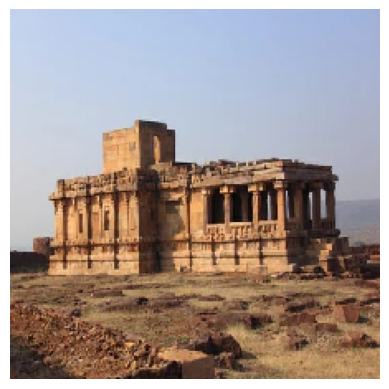

In [73]:
batch = next(train_generator)

plt.imshow(batch[0][1])
plt.axis("off")


In [74]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image, ImageOps


In [75]:
def preprocess_image(img):
    img = Image.fromarray(img.astype("uint8"), "RGB")
    img = ImageOps.fit(img, (224, 224), method=Image.Resampling.LANCZOS)
    img = np.asarray(img).astype("float32") / 255.0
    return img


In [76]:
data_dir = "/content/drive/MyDrive/dataset"   # 📌 change if needed

datagen = ImageDataGenerator(
    validation_split=0.2,
    preprocessing_function=preprocess_image
)

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)


Found 1212 images belonging to 30 classes.
Found 302 images belonging to 30 classes.


In [77]:
base_model = MobileNetV2(input_shape=(224, 224, 3),
                         include_top=False,
                         weights="imagenet")

base_model.trainable = False  # freeze for fast training

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(train_generator.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=outputs)

model.compile(
    optimizer=Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,296,414 (8.76 MB)

 Trainable params: 38,430 (150.12 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [78]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


/tmp/ipython-input-3290333405.py:2: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype("uint8"), "RGB")


Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 37s 730ms/step - accuracy: 0.0227 - loss: 4.0245 - val_accuracy: 0.0629 - val_loss: 3.4728
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 356ms/step - accuracy: 0.0400 - loss: 3.6675 - val_accuracy: 0.0795 - val_loss: 3.2703
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 354ms/step - accuracy: 0.0833 - loss: 3.4313 - val_accuracy: 0.1060 - val_loss: 3.1088
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 349ms/step - accuracy: 0.1128 - loss: 3.2313 - val_accuracy: 0.1689 - val_loss: 2.9707
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.1664 - loss: 3.0442 - val_accuracy: 0.1987 - val_loss: 2.8509
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 348ms/step - accuracy: 0.1654 - loss: 2.9301 - val_accuracy: 0.2185 - val_loss: 2.7470
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.2374 - loss: 2.7117 - val_accuracy: 0.2417 - val_loss: 2.6569
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.2609 - loss: 2.5928 - val_accu

In [79]:
# Unfreeze last 30 layers for fine-tuning
for layer in base_model.layers[-30:]:
    layer.trainable = True

model.compile(
    optimizer=Adam(1e-5),   # 🔥 Small LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


In [80]:
history_finetune = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


/tmp/ipython-input-3290333405.py:2: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img = Image.fromarray(img.astype("uint8"), "RGB")


Epoch 1/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 45s 781ms/step - accuracy: 0.1903 - loss: 2.8429 - val_accuracy: 0.3477 - val_loss: 2.3882
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 357ms/step - accuracy: 0.2567 - loss: 2.5935 - val_accuracy: 0.3609 - val_loss: 2.3391
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 353ms/step - accuracy: 0.3143 - loss: 2.4629 - val_accuracy: 0.3642 - val_loss: 2.2973
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.3072 - loss: 2.3525 - val_accuracy: 0.3808 - val_loss: 2.2581
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step - accuracy: 0.3953 - loss: 2.1323 - val_accuracy: 0.3841 - val_loss: 2.2269
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 350ms/step - accuracy: 0.4266 - loss: 2.0700 - val_accuracy: 0.3775 - val_loss: 2.1955
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.4797 - loss: 1.9156 - val_accuracy: 0.3841 - val_loss: 2.1656
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.4887 - loss: 1.8466 - val_accu

In [81]:
model.save("/content/karnataka_model.h5")


In [82]:
!zip /content/karnataka_model.zip /content/karnataka_model.h5


  adding: content/karnataka_model.h5 (deflated 10%)


In [83]:
from google.colab import files
files.download("/content/karnataka_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
model.save("/content/karnataka_model.keras")


In [85]:
!zip -r /content/karnataka_model.zip /content/karnataka_model.keras


updating: content/karnataka_model.keras (deflated 10%)


In [86]:
from google.colab import files
files.download("/content/karnataka_model.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>